In [1]:
from ProcessingClass import Measurement
from ProcessingClass import Result
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline as cs
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.interpolate import griddata
import pandas as pd
from copy import copy

def takeaverage(exp1_, exp2_):
    res = copy(exp2_)
    res.VAC_dataframe['V'] = np.mean([exp1_.VAC_dataframe['V'].values.copy(), exp2_.VAC_dataframe['V'].values.copy()], axis=0)
    res.JR_dataframe['R']  = np.mean([exp1_.JR_dataframe['R'].values.copy(), exp2_.JR_dataframe['R'].values.copy()], axis=0)
    res.VAC_corr_dataframe['V'] = res.VAC_dataframe['V'].values.copy() - 4 * res.JR_dataframe['J'].values.copy() * res.JR_dataframe['R'].values.copy()
    
    res.overpotential = res.VAC_corr_dataframe['V'].values.copy() - 1.23
    res.slope = np.polyfit(np.log10(res.VAC_corr_dataframe['J'].copy()), res.overpotential.copy(), 1)[0]
    res.tafel_dataframe['V'] = res.VAC_corr_dataframe['V'].values.copy()
    return res

In [2]:
datetimes_start = [
                    (2024, 11, 15, 12,  0, 0), 
                    (2024, 11, 27, 13, 30, 0),
                    (2024, 11, 29, 11,  0, 0), 
                    (2024, 11, 15, 16,  0, 0), 
                    (2024, 11, 29, 13,  0, 0),
                    (2024, 11, 22, 15,  0, 0),  
                    (2024, 11, 19, 12,  0, 0), 
                    (2024, 11, 22, 12,  0, 0), 
                    (2024, 12,  3, 11, 30, 0), 
                    (2024, 12,  4, 13, 30, 0),
                    (2024, 12,  6,  9, 30, 0) 
                    ]

datestimes_end =  [
                    (2024, 11, 15, 13, 30, 0),
                    (2024, 11, 27, 19,  0, 0), 
                    (2024, 11, 29, 14,  0, 0), 
                    (2024, 11, 15, 18, 30, 0), 
                    (2024, 11, 29, 18, 00, 0),
                    (2024, 11, 22, 18,  0, 0),  
                    (2024, 11, 19, 14, 30, 0), 
                    (2024, 11, 22, 14, 30, 0),
                    (2024, 12,  3, 14, 30, 0), 
                    (2024, 12,  4, 17,  0, 0), 
                    (2024, 12,  6, 13, 45, 0) 
                    ]

foldernames = [
                'experiment1 6.5M KOH', 
                'exp7-KOH-Run2',
                'exp8 6.5MKOH plus 5mMLiOH',
                'experiment 2 6.5M KOH 10mM LiOH', 
                'exp9-10mMLi Run2',
                'exp6-6.5MKOHplus25mMLiOH',
                'exp3- 6.5MKOHplus50mM LiOH', 
                'experiment 5- 6.mKOHplus100mM LiOH',
                'experiment10-KOHplusFe',
                'exp11-KOHplusFeplus10mMLiOH',
                'exp12-KOHplusFeplus25mMLiOH',
                'Exp13-KOH-Run3'
                ]

nice_titles = [
                '6.5M KOH', 
                #'Pure KOH att.2',
                '6.5M KOH + 5mM LiOH',
                '6.5M KOH + 10mM LiOH',
                #'KOH + 10m MLiOH 2', 
                '6.5M KOH + 25mM LiOH', 
                '6.5M KOH + 50mM LiOH', 
                '6.5M KOH + 100mM LiOH',
                '6.5M KOH + 25 $\\mu$M Fe$_2$(SO$_4$)$_3$',
                '6.5M KOH + 10mM LiOH + 25 $\\mu$M Fe$_2$(SO$_4$)$_3$',
                '6.5M KOH + 25mM LiOH + 25 $\\mu$M Fe$_2$(SO$_4$)$_3$',
                '6.5M KOH 50$^0$C'
                ]

In [3]:
experiments = []

for foldername in foldernames:
    experiments.append(Result(foldername))

experiments_raw = experiments.copy()

mean_ = takeaverage(experiments[0], experiments[1])
experiments[1] = mean_
experiments.pop(0)

mean_ = takeaverage(experiments[2], experiments[3])
experiments[3] = mean_
experiments.pop(3)

print(len(experiments))

10


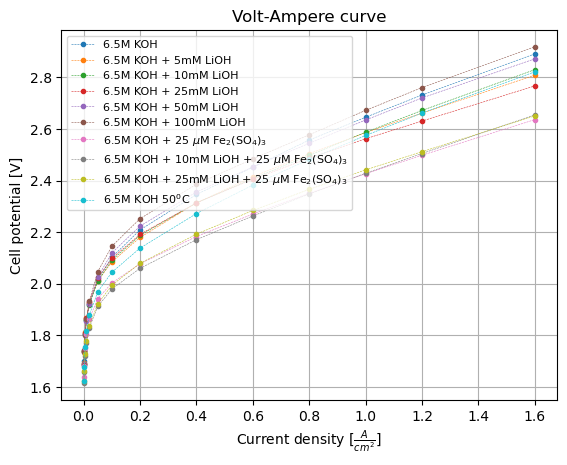

In [4]:
for i in range(max(1,len(experiments))):
    exp = experiments[i]
    exp.VAC_dataframe.sort_values(by = 'J')
    plt.plot(exp.VAC_dataframe['J'], exp.VAC_dataframe['V'], label = nice_titles[i],  marker = '.', linestyle = '--', lw = 0.4)


plt.grid(which='both')
plt.title('Volt-Ampere curve')
plt.xlabel('Current density [$\\frac{A}{cm^2}$]')
plt.ylabel('Cell potential [V]')
plt.legend(fontsize = 8, loc = 'upper left')

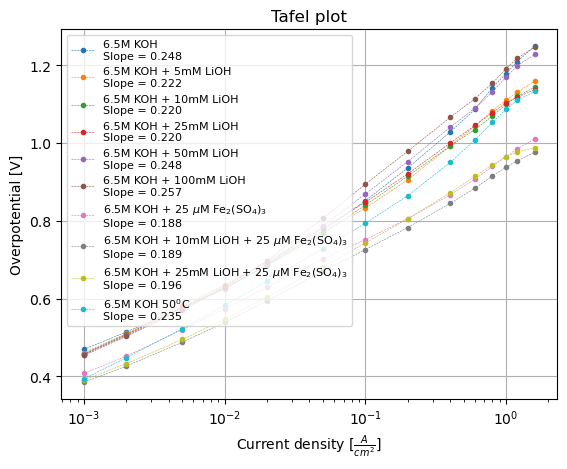

In [5]:
for i in range(max(1,len(experiments))):
    exp = experiments[i]
    exp.JR_dataframe.sort_values(by = 'J')
    plt.plot(exp.JR_dataframe['J'], exp.overpotential, label = nice_titles[i] + f'\nSlope = {exp.slope:.3f}',  marker = '.', linestyle = '--', lw = 0.4)

plt.xscale('log')
plt.grid()
plt.title('Tafel plot')
plt.xlabel('Current density [$\\frac{A}{cm^2}$]')
plt.ylabel('Overpotential [V]')
plt.legend(fontsize = 8)

In [6]:
experiments[0].VAC_corr_dataframe.head()

,J,V
0,0.001,1.699509
1,0.002,1.744279
2,0.005,1.806160
3,0.010,1.856678
4,0.020,1.915784


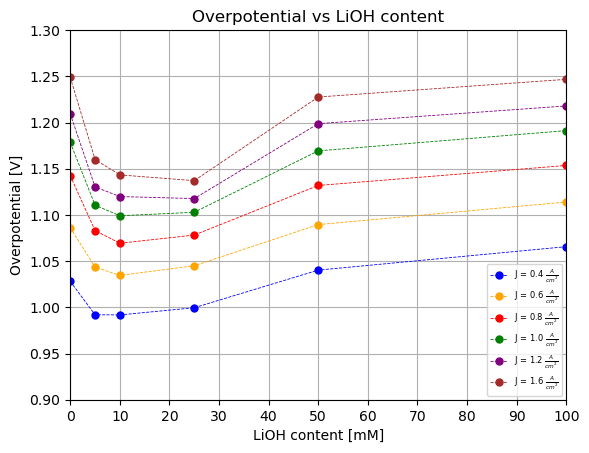

In [7]:
reqs = np.array([0.4, 0.6, 0.8, 1, 1.2, 1.6])
experiments_just_li = experiments[:6]
li_content = np.array([0, 5, 10, 25, 50, 100])
colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'cyan']
overpotentials = []
interpolate = False
baseline = []

for i in range(len(reqs)):
    req = reqs[i]
    baseline.append(experiments_just_li[0].VAC_corr_dataframe[experiments_just_li[0].VAC_corr_dataframe['J'] == req]['V'].values[0])

baseline = np.array(baseline)



for i in range(len(reqs)):
    req = reqs[i]
    list = []
    for exper in experiments_just_li:
        list.append(exper.VAC_corr_dataframe[exper.VAC_corr_dataframe['J'] == req]['V'].values[0])
    list = np.array(list) - 1.23
    overpotentials.append(list)
    plt.plot(li_content, list, label = f'J = {req} '+'$\\frac{A}{cm^2}$', marker = '.', markersize = 10, linestyle = '--', lw = 0.6, color = colors[i])


plt.grid()
plt.xlabel('LiOH content [mM]')
plt.ylabel('Overpotential [V]')
plt.title('Overpotential vs LiOH content')
plt.legend(fontsize = 6, loc = 'lower right')
plt.xlim(0, 100)
plt.ylim(0.9, 1.3)
plt.xticks(np.linspace(0,100,11))

plt.savefig('Overpotential vs LiOH content.png', dpi = 300)

plt.show()

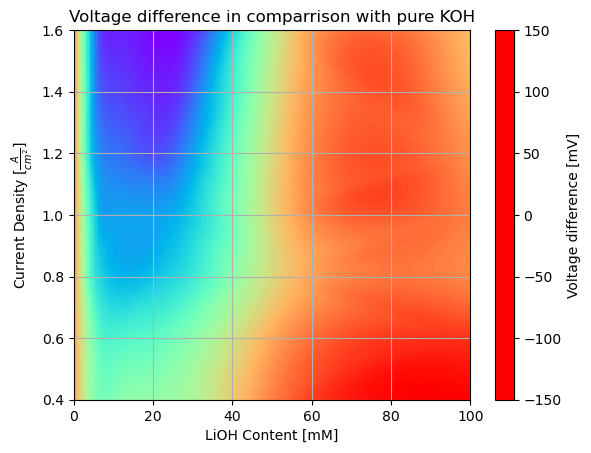

In [8]:
overpotentials = np.array(overpotentials).flatten()
overpotentials = overpotentials - np.array(np.repeat(baseline, len(reqs))).flatten()
overpotentials *=1000

x, y = np.meshgrid(li_content, reqs)
x_new = np.linspace(li_content.min(), li_content.max(), 100)  # Fine LiOH axis
y_new = np.linspace(reqs.min(), reqs.max(), 200)  # Fine J axis
x_fine, y_fine = np.meshgrid(x_new, y_new)

# Perform interpolation
overpotentials_smooth = griddata(
    (x.flatten(), y.flatten()), overpotentials,  (x_fine, y_fine), method='cubic'
)

# Plot the heatmap
plt.imshow(overpotentials_smooth, aspect='auto', cmap='rainbow', origin='lower',
           extent=[li_content.min(), li_content.max(),
                   reqs.min(), reqs.max()])
plt.colorbar(label="Voltage difference [mV]", values=np.linspace(-0.15, 0.15, 6000)*1000, ticks = np.linspace(-0.15, 0.15, 7)*1000)
plt.xlabel("LiOH Content [mM]")
plt.ylabel("Current Density [$\\frac{A}{cm^2}$]")
plt.title("Voltage difference in comparrison with pure KOH")
plt.grid()
#plt.savefig('Heatmap.png', dpi = 300)

plt.show()

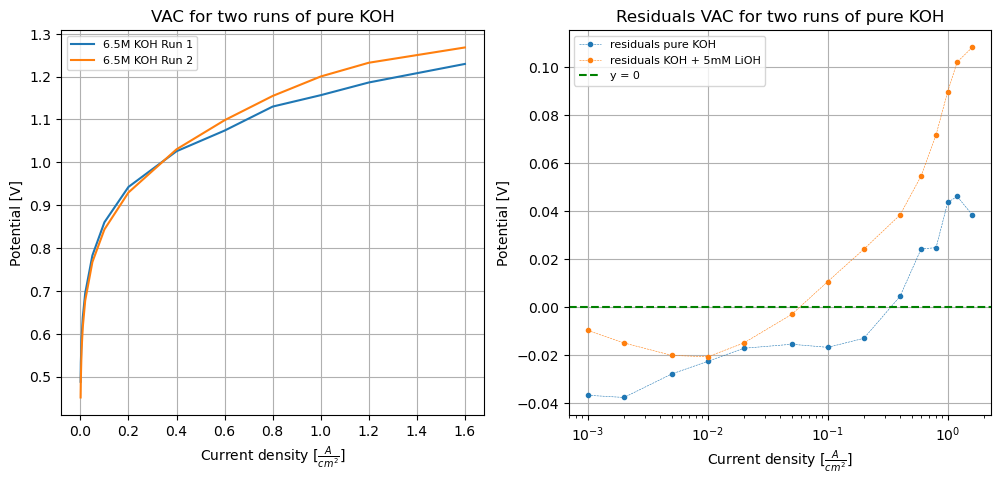

In [9]:
residuals1 = experiments_raw[1].overpotential - experiments_raw[0].overpotential
residuals2 = experiments_raw[1].overpotential - experiments_raw[2].overpotential


fig, ax = plt.subplots(ncols = 2, figsize = (12,5))
ax[0].plot(experiments_raw[0].JR_dataframe['J'], experiments_raw[0].overpotential, label = nice_titles[0] + ' Run 1')
ax[0].plot(experiments_raw[1].JR_dataframe['J'], experiments_raw[1].overpotential, label = nice_titles[0] + ' Run 2')
ax[0].grid()
ax[0].set_title('VAC for two runs of pure KOH')
ax[0].set_xlabel('Current density [$\\frac{A}{cm^2}$]')
ax[0].set_ylabel('Potential [V]')
ax[0].legend(fontsize = 8, loc = 'upper left')
ax[1].plot(exp.JR_dataframe['J'], residuals1, label = 'residuals pure KOH' ,  marker = '.', linestyle = '--', lw = 0.4)
ax[1].plot(exp.JR_dataframe['J'], residuals2, label = 'residuals KOH + 5mM LiOH' ,  marker = '.', linestyle = '--', lw = 0.4)
ax[1].axhline(y=0, linestyle = '--', color = 'green', label = 'y = 0')
ax[1].grid()
ax[1].set_title('Residuals VAC for two runs of pure KOH')
ax[1].set_xlabel('Current density [$\\frac{A}{cm^2}$]')
ax[1].set_ylabel('Potential [V]')
ax[1].set_xscale('log')
ax[1].legend(fontsize = 8, loc = 'upper left')

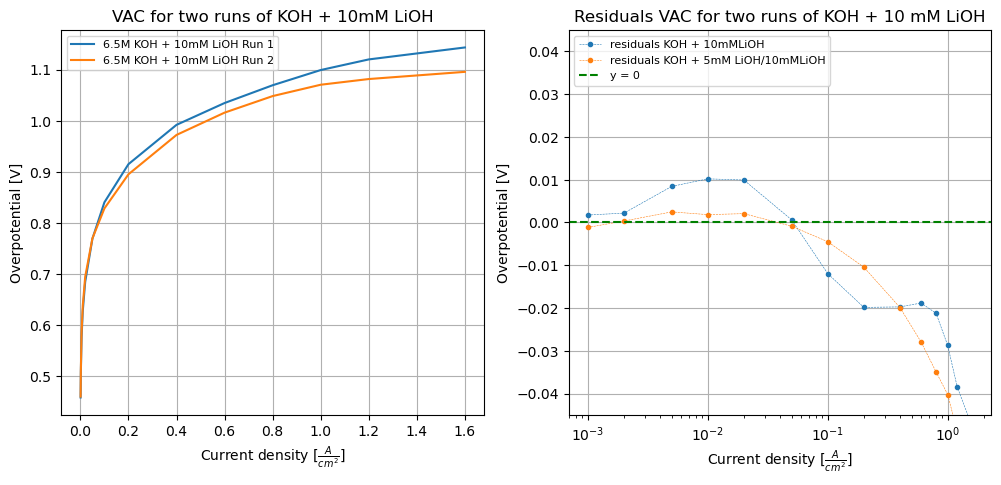

In [10]:
residuals1 = experiments_raw[4].overpotential - experiments_raw[3].overpotential
residuals2 = experiments_raw[4].overpotential - experiments_raw[2].overpotential


fig, ax = plt.subplots(ncols = 2, figsize = (12,5))
ax[0].plot(experiments_raw[0].JR_dataframe['J'], experiments_raw[3].overpotential, label = nice_titles[2] + ' Run 1')
ax[0].plot(experiments_raw[1].JR_dataframe['J'], experiments_raw[4].overpotential, label = nice_titles[2] + ' Run 2')
ax[0].grid()
ax[0].set_title('VAC for two runs of KOH + 10mM LiOH')
ax[0].set_xlabel('Current density [$\\frac{A}{cm^2}$]')
ax[0].set_ylabel('Overpotential [V]')
ax[0].legend(fontsize = 8, loc = 'upper left')

ax[1].plot(exp.JR_dataframe['J'], residuals1, label = 'residuals KOH + 10mMLiOH' ,  marker = '.', linestyle = '--', lw = 0.4)
ax[1].plot(exp.JR_dataframe['J'], residuals2, label = 'residuals KOH + 5mM LiOH/10mMLiOH' ,  marker = '.', linestyle = '--', lw = 0.4)
ax[1].axhline(y=0, linestyle = '--', color = 'green', label = 'y = 0')
ax[1].grid()
ax[1].set_title('Residuals VAC for two runs of KOH + 10 mM LiOH')
ax[1].set_xlabel('Current density [$\\frac{A}{cm^2}$]')
ax[1].set_ylabel('Overpotential [V]')
ax[1].set_xscale('log')
ax[1].set_ylim(-0.045, 0.045)
ax[1].legend(fontsize = 8, loc = 'upper left')

#plt.savefig('Residuals KOH 10 mM LiOH.png', dpi = 300)

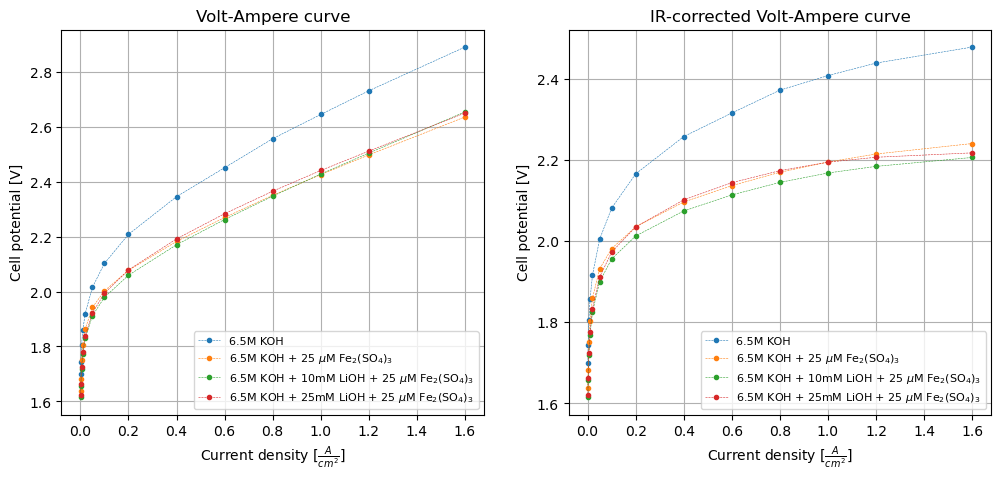

In [11]:
selected_experiments_indices = [0,6, 7,8]

fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))#, sharey = True)


for idx in selected_experiments_indices:
    ax[0].plot(experiments[idx].VAC_dataframe['J'], experiments[idx].VAC_dataframe['V'], label = nice_titles[idx],
               lw = 0.4, marker = '.', linestyle = '--')
    ax[0].legend(fontsize = 8, loc = 'lower right')
    ax[0].grid(True)
    ax[0].set_title('Volt-Ampere curve')
    ax[1].plot(experiments[idx].VAC_corr_dataframe['J'], experiments[idx].VAC_corr_dataframe['V'], label = nice_titles[idx],
               lw = 0.4, marker = '.', linestyle = '--')
    ax[1].legend(fontsize = 8, loc = 'lower right')
    ax[1].grid(True)
    ax[1].set_title('IR-corrected Volt-Ampere curve')
    ax[0].set_xlabel('Current density [$\\frac{A}{cm^2}$]')
    ax[0].set_ylabel('Cell potential [V]')
    ax[1].set_xlabel('Current density [$\\frac{A}{cm^2}$]')
    ax[1].set_ylabel('Cell potential [V]')

plt.savefig('comparrisson plot with iron.png', dpi = 300)

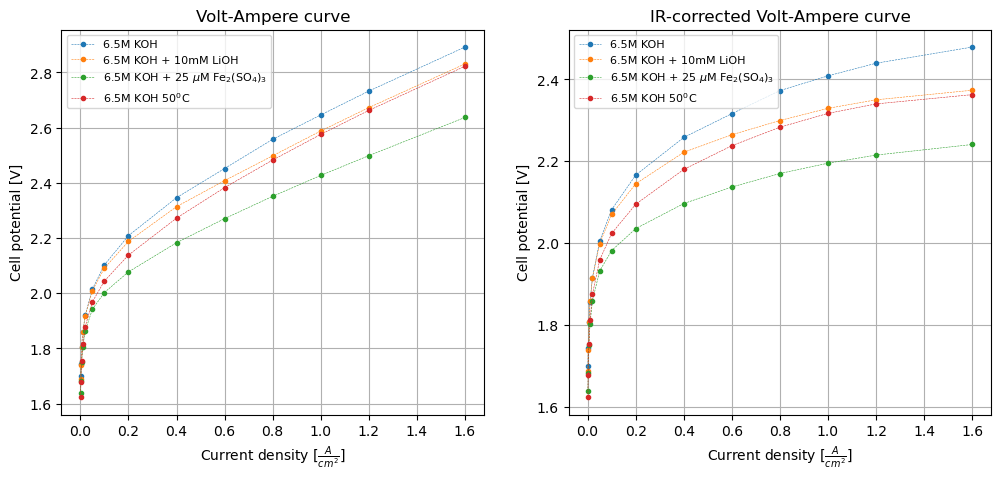

In [12]:
selected_experiments_indices = [0,2, 6, 9]

fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))#, sharey = True)


for idx in selected_experiments_indices:
    ax[0].plot(experiments[idx].VAC_dataframe['J'], experiments[idx].VAC_dataframe['V'], label = nice_titles[idx],
               lw = 0.4, marker = '.', linestyle = '--')
    ax[0].legend(loc = 'upper left', fontsize = 8)
    ax[0].grid(True)
    ax[0].set_title('Volt-Ampere curve')
    ax[1].plot(experiments[idx].VAC_corr_dataframe['J'], experiments[idx].VAC_corr_dataframe['V'], label = nice_titles[idx],
               lw = 0.4, marker = '.', linestyle = '--')
    ax[1].legend(loc = 'upper left', fontsize = 8)
    ax[1].grid(True)
    ax[1].set_title('IR-corrected Volt-Ampere curve')
    ax[0].set_xlabel('Current density [$\\frac{A}{cm^2}$]')
    ax[0].set_ylabel('Cell potential [V]')
    ax[1].set_xlabel('Current density [$\\frac{A}{cm^2}$]')
    ax[1].set_ylabel('Cell potential [V]')

In [13]:
#checking if LiOH has impact on overpotential
data = {
    'x': np.tile(np.log(experiments[0].JR_dataframe['J'].values), 6),
    'y': np.array([experiments[i].overpotential for i in range(6)]).flatten(),
    'group': np.repeat(['Pure', '5mM', '10mM', '25mM', '50mM', '100mM'], 14)
}


model = ols('y ~ C(group) * x', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print('p-value is ',anova_table['PR(>F)'][0])
if anova_table['PR(>F)'][0] < 0.05:
    print('LiOH content has significant influence')
else:
    print('LiOH content has no significant influence')


p-value is  7.842271499291425e-06
LiOH content has significant influence


In [14]:
#Checking if runs for pure KOH are the same
data = {
    'x': np.tile(np.log(experiments_raw[0].JR_dataframe['J'].values), 2),
    'y': np.array([experiments_raw[i].overpotential for i in [0,1]]).flatten(),
    'group': np.repeat(['Pure, run1', 'Pure, run2'], 14)
}


model = ols('y ~ C(group) * x', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print('p-value is ',anova_table['PR(>F)'][0])

if anova_table['PR(>F)'][0] < 0.05:
    print('The experiments are different')
else:
    print('The experiments are the same')

p-value is  0.9817962647298432
The experiments are the same
